# Kaggle Competition: MultiClass classification

<img src="https://octodex.github.com/images/octocat-de-los-muertos.jpg" alt="Cat" title="Cat" width="350" height="200" />
*(image from octodex github)*

**We will first use the dataset training, metadata image and sentiment data to predict the Adoption Speed**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import partial
from math import sqrt

# LightGBM
import lightgbm as lgb
import scipy as sp

# Load scikit's classifier library
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import cohen_kappa_score,mean_squared_error, accuracy_score, confusion_matrix, f1_score,classification_report

from xgboost import XGBClassifier, plot_importance

## Data Preparation 

In [3]:
#Load Data
train =pd.read_csv(r'C:\Users\alorenzodebrionne\Documents\BusinessDecision\Projects\Kaggle\train_features.csv',index_col=0)

In [4]:
train.columns

Index(['Quantity', 'Fee', 'VideoAmt', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'sentiment_document_score', 'sentiment_document_magnitude',
       'metadata_topicality_max', 'metadata_topicality_mean',
       ...
       'MaturitySize_4', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3',
       'Vaccinated_1', 'Vaccinated_2', 'Vaccinated_3', 'FurLength_1',
       'FurLength_2', 'FurLength_3'],
      dtype='object', length=116)

In [5]:
train.head(1)

,Quantity,Fee,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,sentiment_document_score,sentiment_document_magnitude,metadata_topicality_max,metadata_topicality_mean,...,MaturitySize_4,Sterilized_1,Sterilized_2,Sterilized_3,Vaccinated_1,Vaccinated_2,Vaccinated_3,FurLength_1,FurLength_2,FurLength_3
0,1,100,0,86e1089a3,1.0,2,0.3,2.4,0.990786,0.830798,...,0,0,1,0,0,1,0,1,0,0


## Train/Test/Validation Sets

We are going to use 75% of the data for training and the remaining 20% to test the model. 
We will tune the hyperparameters using cross validation datasets. 

In [31]:
#Extracting Features and Output
ids=train[['PetID']]
train_analysis=train.drop(['PetID'],axis=1)

X, y = train_analysis.loc[:, train_analysis.columns != 'AdoptionSpeed'], train_analysis['AdoptionSpeed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)



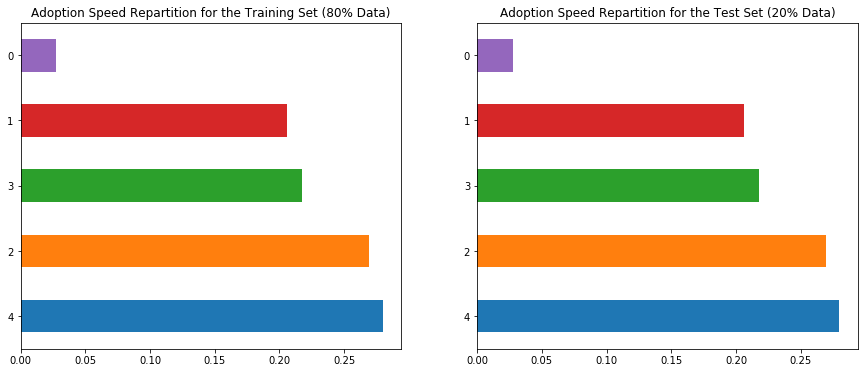

In [7]:
plt.subplot(1, 2, 1)
prob_train  =y_train.value_counts(normalize=True)
prob_train.plot(kind='barh',figsize =(20,6))
plt.title('Adoption Speed Repartition for the Training Set (75% Data)')
plt.subplot(1, 2, 2)

prob  =y_test.value_counts(normalize=True)
prob.plot(kind='barh', figsize =(15,6))
plt.title('Adoption Speed Repartition for the Test Set (25% Data)')
plt.show()

## Evaluation with Quadratic Weighted Kappa

In [8]:
# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)


## Optimized Boundaries

In [9]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.7, 2.6, 3.6]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

## Cross Validation

In a first step we divide our data into a training(75% of Data) and a testing set (25% of Data). To tune the hyperparameter and avoid overfitting we used the technique of Cross Validation (CV). For K-Fold CV, we further split our training set into K number of subsets, called folds.We then iteratively fit the model K times, each time training the data on K-1 of the folds and evaluating on the Kth fold. For hyperparameter tuning, we perform many iterations of the entire K-Fold CV process, each time using different model settings. We then compare all of the models, select the best one! At the very end of training, we average the performance on each of the folds to come up with final validation metrics for the model.

<img src="https://i.imgur.com/amekoez.jpg" alt="Cat" title="Cat" width="700" height="500" />

In [27]:
def cross_val(model):
    X = np.array(X_train)
    y = np.array(y_train)
    coeff = np.empty((1,4))
    cv_scores=[]
    fold=1
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    print(skf.get_n_splits(X, y))

    for train_index, val_index in skf.split(X, y):
        xtrain, xvalid = X[train_index], X[val_index]
        ytrain, yvalid = y[train_index], y[val_index]
        w = y_train.value_counts()
        weights = {i : np.sum(w) / w[i] for i in w.index}
        print(weights)

        model.fit(
            xtrain, ytrain,
            eval_metric=["error", "logloss"],
            eval_set=[(xvalid, yvalid)],
            verbose=100,
            early_stopping_rounds=100
        )

        #model.fit(xtrain, ytrain)
        valid_preds = model.predict(xvalid, num_iteration=model.best_iteration_)
        yvalid = np.array(yvalid).tolist()
        optR = OptimizedRounder()
        optR.fit(valid_preds, yvalid)

        coefficients = optR.coefficients()
        valid_p = optR.predict(valid_preds, coefficients)

        scr = quadratic_weighted_kappa(yvalid, valid_p)
        cv_scores.append(scr)

        print("QWK = {}. Coef = {}".format(scr, coefficients))
        coefficients.reshape((4, 1))

        coeff = np.vstack([coeff, coefficients])
        fold += 1


    coeff = np.delete(coeff, (0), axis=0)
    global coefficient_mean
    coefficient_mean = coeff.mean(axis=0)
    print("Coef Mean ={}".format(coefficient_mean))

## Features Selection

Select the features by examining only the training set and avoid overfitting (using LightGBM)

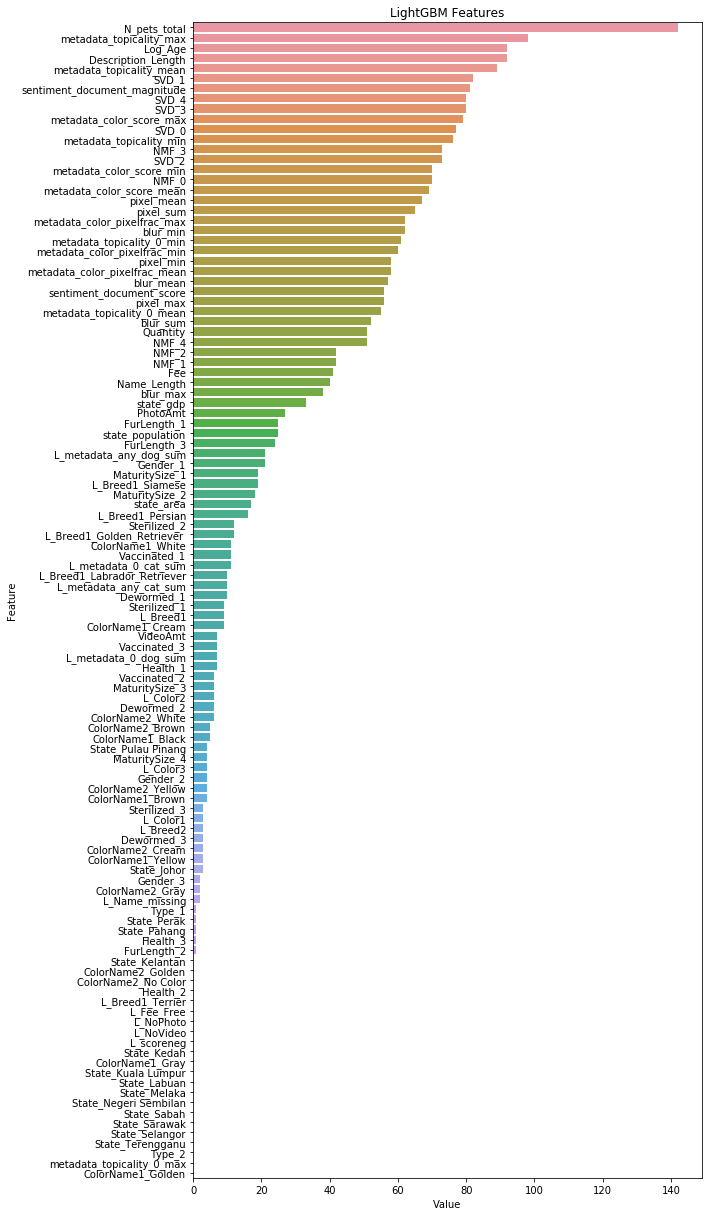

In [11]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 17))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()


features_selection = SelectFromModel(model, threshold='1.25*median') # The Threshold is the median of features importance*1.25 
features_selection.fit(X_train, y_train)


features_selection_support = features_selection.get_support()
features_selection = X_train.loc[:,features_selection_support].columns.tolist()



In [35]:
X_train =X_train.loc[:,features_selection]

## Modelisation

In a first step we divide our data into a training(75% of Data) and a testing set (25% of Data). To tune the hyperparameter and avoid overfitting we used the technique of Cross Validation (CV). For K-Fold CV, we further split our training set into K number of subsets, called folds.We then iteratively fit the model K times, each time training the data on K-1 of the folds and evaluating on the Kth fold. For hyperparameter tuning, we perform many iterations of the entire K-Fold CV process, each time using different model settings. We then compare all of the models, select the best one! At the very end of training, we average the performance on each of the folds to come up with final validation metrics for the model.

### Evaluation with Cohen Kappa measure

In [13]:
def evaluate(y_pred, y_true):
  
    cohen_kappa= cohen_kappa_score(y_true, y_pred)
    accuracy=accuracy_score(y_true,y_pred)
    f1=f1_score(y_true,y_pred,average='micro')
    classification=classification_report(y_true,y_pred)
    
    #Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20,6))
    
    sns.heatmap(cm, annot=True)
    plt.title('Confusion matrix')
    plt.figure(figsize = (5,4))
    plt.show()
    #Evaluation Metrics
    print('Cohen Kappa: {:0.2f}.'.format(cohen_kappa))
    print('Accuracy Score: {:0.2f}%.'.format(accuracy))
    print('F1 Score: {:0.2f}%.'.format(f1))
    

## Random Forest

This will try out 3 X 2 X 4 X 3 X 2 X 1 = **144 combinations of settings!**


In [488]:
gridParams = {'min_samples_split': [2],
                      'min_samples_leaf': [ 3],
                      'max_depth': [10],
                      'max_features':[12],
                      'n_estimators': [500],
                      'class_weight':[{0: w} for w in [5,6]]}

print(gridParams)

{'min_samples_split': [2], 'n_estimators': [100], 'max_depth': [10], 'class_weight': [{0: 5}, {0: 6}], 'min_samples_leaf': [3], 'max_features': [12]}


In [489]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 
rf_random = GridSearchCV( rf, gridParams, cv=StratifiedKFold(n_splits  =5),refit=True, verbose=0)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2], 'n_estimators': [100], 'max_depth': [10], 'class_weight': [{0: 5}, {0: 6}], 'min_samples_leaf': [3], 'max_features': [12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [666]:
# Fit the random search model
rf_random.fit(x_train_res, y_train_res)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2], 'n_estimators': [100], 'max_depth': [10], 'class_weight': [{0: 5}, {0: 6}], 'min_samples_leaf': [3], 'max_features': [12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [490]:
rf_random.best_params_

{'class_weight': {0: 5},
 'max_depth': 10,
 'max_features': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

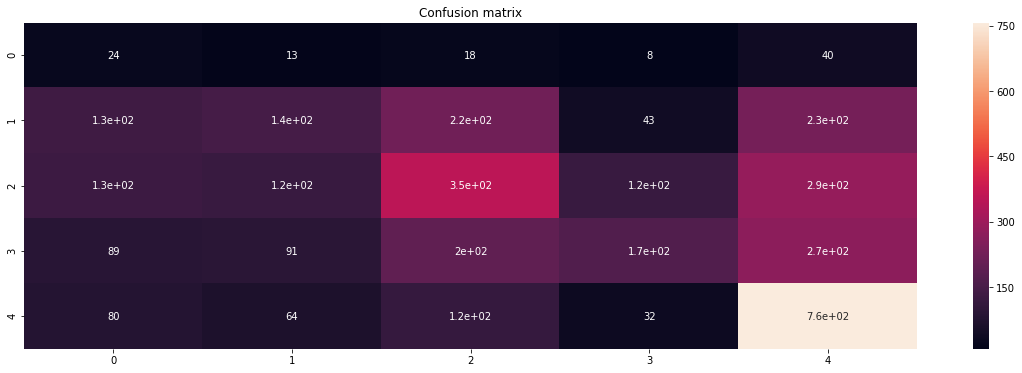

Cohen Kappa: 0.20.
Accuracy Score: 0.39%.
F1 Score: 0.39%.
              precision    recall  f1-score   support

           0       0.05      0.23      0.09       103
           1       0.33      0.18      0.24       773
           2       0.39      0.35      0.37      1009
           3       0.45      0.21      0.28       815
           4       0.48      0.72      0.57      1049

   micro avg       0.39      0.39      0.39      3749
   macro avg       0.34      0.34      0.31      3749
weighted avg       0.41      0.39      0.37      3749



In [667]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [493]:
y_pred = pd.DataFrame() 
y_pred['predictions'] = rf_random.predict(X_test)
prob_rf = pd.concat([y_pred,pd.DataFrame(rf_random.predict_proba(X_test))], axis=1)
prob_rf= prob_rf.add_prefix('rf_')
++

prob_rf

,rf_predictions,rf_0,rf_1,rf_2,rf_3,rf_4
0,1,0.088382,0.344331,0.283241,0.175670,0.108375
1,2,0.050440,0.181700,0.352273,0.300782,0.114805
2,3,0.025019,0.095215,0.258519,0.454358,0.166888
3,1,0.080272,0.260768,0.256458,0.174385,0.228117
4,2,0.079541,0.259921,0.306619,0.205744,0.148176
5,4,0.110248,0.160567,0.228488,0.186756,0.313941
6,4,0.060590,0.220274,0.183510,0.136926,0.398701
7,4,0.036380,0.157215,0.294639,0.169584,0.342182
8,1,0.126370,0.267430,0.191216,0.152956,0.262028
9,4,0.027065,0.096211,0.228548,0.289984,0.358193


In [636]:
# Choose and initialize a model.
clf = RandomForestClassifier(bootstrap=True, criterion = 'gini', max_depth=80,
                             max_features='auto', min_samples_leaf=5,
                             min_samples_split=5, n_estimators=200)

# Divide the training data into k-folds, k=4 here.
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1812).split(X_train, y_train))

In [663]:
from imblearn.over_sampling import SMOTE
ratio = {0: 1, 1: 1, 2: 1, 3:1, 4:1}

sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
(pd.Series(y_train_res)).value_counts()

4    3148
3    3148
2    3148
1    3148
0    3148
dtype: int64

## XGBoost

More information on parameters tuning in: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
n_estimators = [100]
learning_rate = [0.1]
max_depth =[10]
colsample_bytree=[0.3]

# Create the random grid
gridParams = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree,
               'class_weight':[{0: w} for w in [5,6]]}


In [495]:
from xgboost.sklearn import XGBClassifier

xgb1 = XGBClassifier()

clf = GridSearchCV(xgb1, gridParams,
                   cv=StratifiedKFold(n_splits  =5), 
                   refit=True, verbose=0)

# Fit the random search model
clf.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'class_weight': [{0: 5}, {0: 6}], 'max_depth': [10], 'colsample_bytree': [0.3], 'n_estimators': [100], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [496]:
clf.best_params_

{'class_weight': {0: 5},
 'colsample_bytree': 0.3,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 100}

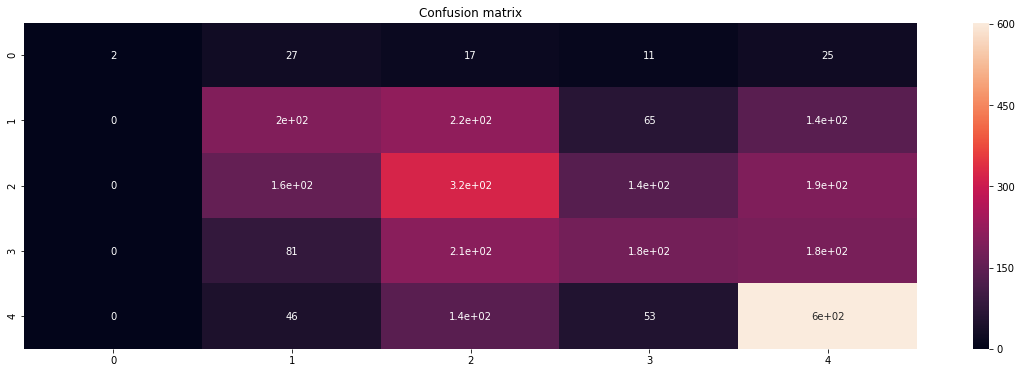

Cohen Kappa: 0.24.
Accuracy Score: 0.43%.
F1 Score: 0.43%.


In [498]:
best_xgb = clf.best_estimator_
xgb_accuracy = evaluate(best_xgb, X_test, y_test)

In [499]:
y_pred = pd.DataFrame() 
y_pred['predictions'] = clf.predict(X_test)
prob_xgb = pd.concat([y_pred,pd.DataFrame(clf.predict_proba(X_test))], axis=1)
prob_xgb= prob_xgb.add_prefix('xgb_')

prob_xgb

,xgb_predictions,xgb_0,xgb_1,xgb_2,xgb_3,xgb_4
0,2,0.015123,0.405522,0.428979,0.125914,0.024462
1,3,0.009157,0.173051,0.217140,0.522842,0.077810
2,3,0.004423,0.037160,0.194857,0.577515,0.186044
3,1,0.012998,0.296504,0.213772,0.233895,0.242831
4,2,0.010842,0.230417,0.439176,0.186889,0.132676
5,4,0.015718,0.218260,0.300786,0.142827,0.322410
6,1,0.009188,0.440424,0.200411,0.069339,0.280638
7,4,0.004198,0.070784,0.325147,0.252489,0.347382
8,1,0.025085,0.445456,0.118202,0.205345,0.205912
9,4,0.004446,0.042179,0.202621,0.298849,0.451905


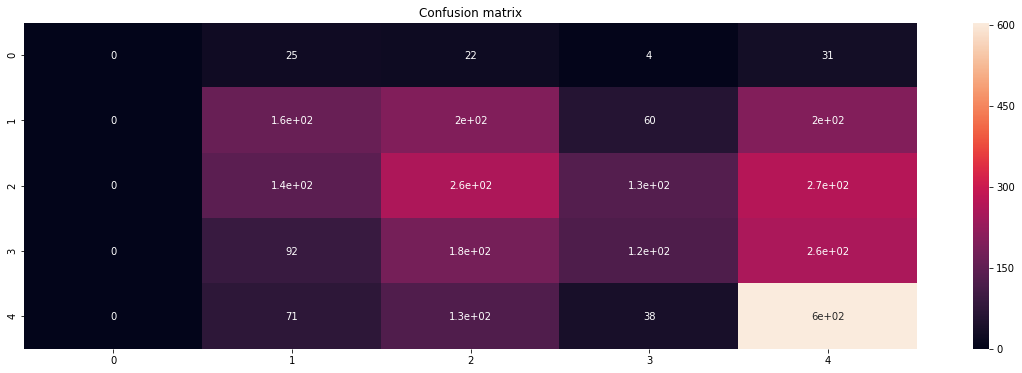

Cohen Kappa: 0.17.
Accuracy Score: 0.38%.
F1 Score: 0.38%.


In [502]:
best_dt = dt_cv.best_estimator_
dt_accuracy = evaluate(best_dt, X_test, y_test)

In [503]:
y_pred = pd.DataFrame() 
y_pred['predictions'] = dt_cv.predict(X_test)
prob_dt = pd.concat([y_pred,pd.DataFrame(dt_cv.predict_proba(X_test))], axis=1)
prob_dt= prob_dt.add_prefix('dt_')

prob_dt

,dt_predictions,dt_0,dt_1,dt_2,dt_3,dt_4
0,1,0.044878,0.380488,0.333659,0.160976,0.080000
1,3,0.015544,0.163731,0.382383,0.398964,0.039378
2,3,0.015544,0.163731,0.382383,0.398964,0.039378
3,1,0.044878,0.380488,0.333659,0.160976,0.080000
4,2,0.014174,0.223955,0.318923,0.233877,0.209072
5,4,0.026415,0.066038,0.166038,0.105660,0.635849
6,4,0.026415,0.066038,0.166038,0.105660,0.635849
7,2,0.014174,0.223955,0.318923,0.233877,0.209072
8,4,0.032857,0.172857,0.160000,0.184286,0.450000
9,4,0.010720,0.081164,0.223583,0.316998,0.367534


## LightGBM

In [36]:
lgb_params = {
'boosting_type': 'gbdt',
'objective': 'regression',
'learning_rate': 0.005,
'subsample': .8,
'colsample_bytree': 0.8,
'min_split_gain': 0.006,
'min_child_samples': 150,
'min_child_weight': 0.1,
'max_depth': 17,
'n_estimators': 1000,
'num_leaves': 80,
'silent': -1,
'verbose': -1,
'max_depth': 11,
'random_state': 2018
}
    
model = lgb.LGBMRegressor(**lgb_params)

cross_val(model)

#Prediction
y_pred=model.predict(X_train)


5
{0: 36.625407166123779, 1: 4.8528269313767805, 2: 3.7133421400264202, 3: 4.6006546644844519, 4: 3.5717916137229988}
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.277
[200]	valid_0's l2: 1.22001
[300]	valid_0's l2: 1.18791
[400]	valid_0's l2: 1.16759
[500]	valid_0's l2: 1.1533
[600]	valid_0's l2: 1.14159
[700]	valid_0's l2: 1.13333
[800]	valid_0's l2: 1.12806
[900]	valid_0's l2: 1.12367
[1000]	valid_0's l2: 1.12066
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.12066
QWK = 0.4210854662293575. Coef = [ 0.53968897  1.96260644  2.43602981  2.91172774]
{0: 36.625407166123779, 1: 4.8528269313767805, 2: 3.7133421400264202, 3: 4.6006546644844519, 4: 3.5717916137229988}
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.27007
[200]	valid_0's l2: 1.20746
[300]	valid_0's l2: 1.17228
[400]	valid_0's l2: 1.15067
[500]	valid_0's l2: 1.13446
[600]	valid_0's l2: 1.1242
[700]	valid_0's l2: 1.11632
[800]	v

In [37]:
optR=OptimizedRounder()
y_true = pd.DataFrame(y_train)
y_true.reset_index(inplace=True,drop=False)

predictions = optR.predict(y_pred, coefficient_mean).astype(int)
pred_lgb = pd.concat([pd.DataFrame(y_pred),y_true,pd.DataFrame(predictions)],axis=1,ignore_index=True)
pred_lgb.columns = ['y_pred','index','y_true','y_pred_class']

pred_lgb['y_pred_class'].value_counts()

2    3614
4    3361
3    2281
1    1988
Name: y_pred_class, dtype: int64

C:\Users\alorenzodebrionne\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


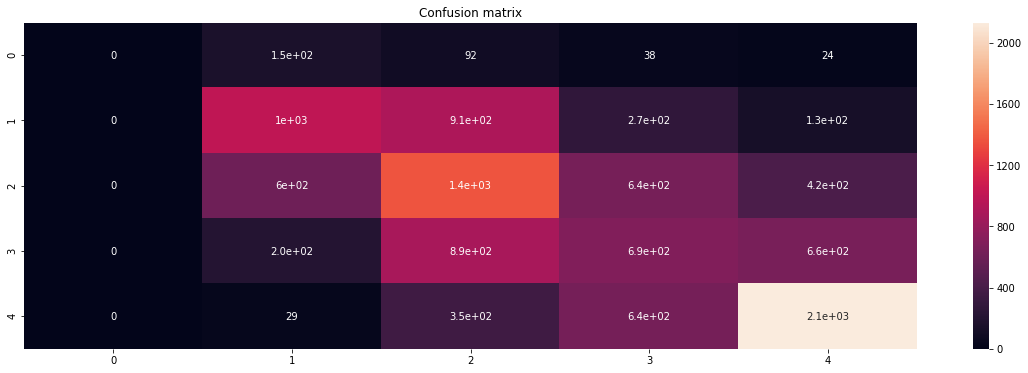

Cohen Kappa: 0.28.
Accuracy Score: 0.46%.
F1 Score: 0.46%.


In [38]:
evaluate(pred_lgb['y_pred_class'].tolist(), pred_lgb['y_true'].tolist())

## Gradient Boosted Classifier

In [606]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)
y_pred = gbk.predict(X_test)
acc_gbk = cohen_kappa_score(y_pred, y_test)
print(acc_gbk)

0.22578957543


## Support Vector Machine

## Nearest Neighbors

## Stochastic Gradient Descent

## Neural Network

## Combine forecasts predictions 

In [522]:
#y_test =y_test.reset_index(drop=False)

full_table=pd.concat([prob_lgb,prob_xgb,prob_rf,prob_dt,y_test],axis=1)
full_table.head()

,lgbm_predictions,lgbm_0,lgbm_1,lgbm_2,lgbm_3,lgbm_4,lgbm_level_0,lgbm_index,lgbm_AdoptionSpeed,xgb_predictions,...,rf_4,dt_predictions,dt_0,dt_1,dt_2,dt_3,dt_4,level_0,index,AdoptionSpeed
0,1,0.114892,0.413519,0.268663,0.141538,0.061388,0,8933,0,2,...,0.108375,1,0.044878,0.380488,0.333659,0.160976,0.080000,0,8933,0
1,3,0.082405,0.144350,0.268917,0.414146,0.090181,1,1879,2,3,...,0.114805,3,0.015544,0.163731,0.382383,0.398964,0.039378,1,1879,2
2,3,0.033610,0.089204,0.237107,0.482326,0.157753,2,1521,2,3,...,0.166888,3,0.015544,0.163731,0.382383,0.398964,0.039378,2,1521,2
3,2,0.103812,0.229688,0.247245,0.202718,0.216537,3,4817,2,1,...,0.228117,1,0.044878,0.380488,0.333659,0.160976,0.080000,3,4817,2
4,2,0.075871,0.272441,0.306823,0.204438,0.140427,4,7135,1,2,...,0.148176,2,0.014174,0.223955,0.318923,0.233877,0.209072,4,7135,1


In [555]:
full_table['proba0'] = full_table[['lgbm_0','xgb_0','rf_0','dt_0']].median(axis=1)
full_table['proba1'] = full_table[['lgbm_1','xgb_1','rf_1','dt_1']].median(axis=1)
full_table['proba2'] = full_table[['lgbm_2','xgb_2','rf_2','dt_2']].median(axis=1)
full_table['proba3'] = full_table[['lgbm_3','xgb_3','rf_3','dt_3']].median(axis=1)
full_table['proba4'] = full_table[['lgbm_4','xgb_4','rf_4','dt_4']].median(axis=1)

In [556]:
full_table

,lgbm_predictions,lgbm_0,lgbm_1,lgbm_2,lgbm_3,lgbm_4,lgbm_level_0,lgbm_index,lgbm_AdoptionSpeed,xgb_predictions,...,level_0,index,AdoptionSpeed,proba0,proba1,proba2,proba3,proba4,probscore,new_prediction
0,1,0.114892,0.413519,0.268663,0.141538,0.061388,0,8933,0,2,...,0,8933,0,0.015123,0.344331,0.268663,0.125914,0.024462,0.428979,2
1,3,0.082405,0.144350,0.268917,0.414146,0.090181,1,1879,2,3,...,1,1879,2,0.009157,0.144350,0.217140,0.300782,0.039378,0.522842,3
2,3,0.033610,0.089204,0.237107,0.482326,0.157753,2,1521,2,3,...,2,1521,2,0.004423,0.037160,0.194857,0.398964,0.039378,0.577515,3
3,2,0.103812,0.229688,0.247245,0.202718,0.216537,3,4817,2,1,...,3,4817,2,0.012998,0.229688,0.213772,0.160976,0.080000,0.380488,1
4,2,0.075871,0.272441,0.306823,0.204438,0.140427,4,7135,1,2,...,4,7135,1,0.010842,0.223955,0.306619,0.186889,0.132676,0.439176,2
5,4,0.097006,0.162539,0.217233,0.133760,0.389462,5,14041,1,4,...,5,14041,1,0.015718,0.066038,0.166038,0.105660,0.313941,0.635849,4
6,4,0.136371,0.266632,0.192770,0.127054,0.277173,6,11251,4,1,...,6,11251,4,0.009188,0.066038,0.166038,0.069339,0.277173,0.635849,4
7,4,0.054375,0.142960,0.239295,0.195734,0.367637,7,12999,2,4,...,7,12999,2,0.004198,0.070784,0.239295,0.169584,0.209072,0.367637,4
8,4,0.145682,0.251371,0.110841,0.111295,0.380811,8,6459,1,1,...,8,6459,1,0.025085,0.172857,0.110841,0.111295,0.205912,0.450000,4
9,4,0.052031,0.082854,0.243587,0.294462,0.327066,9,701,2,4,...,9,701,2,0.004446,0.042179,0.202621,0.289984,0.327066,0.451905,4


In [557]:
full_table['probscore'] = full_table[['proba0','proba1','proba2','proba3','proba4']].max(axis=1)

In [558]:
full_table

,lgbm_predictions,lgbm_0,lgbm_1,lgbm_2,lgbm_3,lgbm_4,lgbm_level_0,lgbm_index,lgbm_AdoptionSpeed,xgb_predictions,...,level_0,index,AdoptionSpeed,proba0,proba1,proba2,proba3,proba4,probscore,new_prediction
0,1,0.114892,0.413519,0.268663,0.141538,0.061388,0,8933,0,2,...,0,8933,0,0.015123,0.344331,0.268663,0.125914,0.024462,0.344331,2
1,3,0.082405,0.144350,0.268917,0.414146,0.090181,1,1879,2,3,...,1,1879,2,0.009157,0.144350,0.217140,0.300782,0.039378,0.300782,3
2,3,0.033610,0.089204,0.237107,0.482326,0.157753,2,1521,2,3,...,2,1521,2,0.004423,0.037160,0.194857,0.398964,0.039378,0.398964,3
3,2,0.103812,0.229688,0.247245,0.202718,0.216537,3,4817,2,1,...,3,4817,2,0.012998,0.229688,0.213772,0.160976,0.080000,0.229688,1
4,2,0.075871,0.272441,0.306823,0.204438,0.140427,4,7135,1,2,...,4,7135,1,0.010842,0.223955,0.306619,0.186889,0.132676,0.306619,2
5,4,0.097006,0.162539,0.217233,0.133760,0.389462,5,14041,1,4,...,5,14041,1,0.015718,0.066038,0.166038,0.105660,0.313941,0.313941,4
6,4,0.136371,0.266632,0.192770,0.127054,0.277173,6,11251,4,1,...,6,11251,4,0.009188,0.066038,0.166038,0.069339,0.277173,0.277173,4
7,4,0.054375,0.142960,0.239295,0.195734,0.367637,7,12999,2,4,...,7,12999,2,0.004198,0.070784,0.239295,0.169584,0.209072,0.239295,4
8,4,0.145682,0.251371,0.110841,0.111295,0.380811,8,6459,1,1,...,8,6459,1,0.025085,0.172857,0.110841,0.111295,0.205912,0.205912,4
9,4,0.052031,0.082854,0.243587,0.294462,0.327066,9,701,2,4,...,9,701,2,0.004446,0.042179,0.202621,0.289984,0.327066,0.327066,4


In [559]:
full_table['new_prediction'] = np.where(full_table['proba0'] == full_table['probscore'],0,full_table['new_prediction'])
full_table['new_prediction'] = np.where(full_table['proba1'] == full_table['probscore'], 1, full_table['new_prediction'])
full_table['new_prediction'] = np.where(full_table['proba2'] == full_table['probscore'], 2, full_table['new_prediction'])
full_table['new_prediction'] = np.where(full_table['proba3'] == full_table['probscore'], 3, full_table['new_prediction'])
full_table['new_prediction'] = np.where(full_table['proba4'] == full_table['probscore'], 4, full_table['new_prediction'])


In [561]:
cohen_kappa= cohen_kappa_score(full_table['AdoptionSpeed'], full_table['new_prediction'])

In [562]:
cohen_kappa

0.23402176602649005

In [563]:
full_table['AdoptionSpeed'].value_counts()

4    840
2    807
3    652
1    618
0     82
Name: AdoptionSpeed, dtype: int64

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=10, verbose=5)
rfe_selector.fit(X_norm, y)